# Reorganization
Run simple dipole test case (with few loops) to make sure our reorganization is working properly.

In [11]:
import os
import subprocess
import time

import dask
import dask.distributed
import numpy as np
import scipy.interpolate
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn
from sunpy.map import Map,GenericMap
from sunpy.instr.aia import aiaprep
import fiasco
import synthesizAR
import synthesizAR.maps
from synthesizAR.model_ext import UniformHeating, EbtelInterface
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.atomic import Ion,Element,EmissionModel
from solarbextrapolation.example_data_generator import dummyDataToMap

%matplotlib inline

In [2]:
client = dask.distributed.Client()
client

Client Scheduler: tcp://127.0.0.1:60380 Dashboard: http://127.0.0.1:8787,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


## Synthetic HMI Map
First, make a basic dipole map.

In [ ]:
def make_synthetic_map(xrange,yrange,shape,spots):
    delta_x = xrange[1] - xrange[0]
    delta_y = yrange[1] - yrange[0]
    dx = delta_x/arr_grid_shape[0]
    dy = delta_y/arr_grid_shape[1]
    synthetic_hmi_data = np.zeros(arr_grid_shape)
    xphysical,yphysical = np.meshgrid(np.arange(arr_grid_shape[0])*dx,np.arange(arr_grid_shape[1])*dy)
    for spot in spots:
        if spot[0].unit is u.percent:
            pos = u.Quantity([spot[0][0].value/100.*delta_x + xrange[0],
                              spot[0][1].value/100.*delta_y + yrange[0]])
        else:
            pos = spot[0]
        if spot[1].unit is u.percent:
            sigma = spot[1].value/100.*delta_x
        else:
            sigma = spot[1]
        An_max   = spot[2].value
        An_x     = pos[0]
        An_y     = pos[1]
        An_Dx    = xphysical - An_x + xrange[0]
        An_Dy    = yphysical - An_y + yrange[0]
        An_DxSqu = An_Dx.value**2.0
        An_DySqu = An_Dy.value**2.0
        An_Sigma = sigma.value

        # So this contibution is calculated and added.
        synthetic_hmi_data += An_max * np.exp( - ( (An_DxSqu + An_DySqu) / (2 * An_Sigma**2.0)) )
        
    synthetic_hmi_map = dummyDataToMap(synthetic_hmi_data,xrange,yrange)
    test = Map('/Users/willbarnes/sunpy/data/hmi_m_45s_2017_08_20_18_16_30_tai_magnetogram.fits')
    for key in ['ctype1','ctype2','rsun_ref','rsun_obs','dsun_ref','dsun_obs',
                'wcsname','crlt_obs','t_obs','date-obs']:
        synthetic_hmi_map.meta[key] = test.meta[key]
        
    return synthetic_hmi_map

In [ ]:
arr_grid_shape = [ 300, 300]
xrange = u.Quantity([ -150.0, 150.0 ], u.arcsec)
yrange = u.Quantity([ -150.0, 150.0 ], u.arcsec)
spots = [
    ( u.Quantity([65,50],u.percent), 5*u.percent, -5e3*u.Gauss),
    ( u.Quantity([35,50],u.percent), 5*u.percent,  5e3*u.Gauss)
]

In [ ]:
hmi_map = make_synthetic_map(xrange,yrange,arr_grid_shape,spots)

## Build Field
Assemble the extrapolated field and trace streamlines.

In [ ]:
field = synthesizAR.Skeleton(hmi_fits_file=hmi_map,resample=u.Quantity([100,100],'pix'))

In [ ]:
zrange = u.Quantity([0,300],'arcsec')
zshape = 100

In [ ]:
field.extrapolate_field(zshape,zrange)

In [ ]:
field.extract_streamlines(100,
                          close_threshold=0.05,
                          mask_threshold=0.2,
                          safety=2,
                          loop_length_range=[1e9,2e10]*u.cm,
                          direction=-1)

In [ ]:
field.peek()

In [ ]:
field.make_loops()

In [ ]:
plt.hist([loop.full_length.to(u.Mm).value for loop in field.loops],bins='scott',histtype='step',lw=2);
plt.xscale('log')

## Loop Models

In [ ]:
class SingleEventModel(UniformHeating):
    @property
    def number_events(self):
        return 1
heating_options = {'duration':200,'average_waiting_time':1000,'duration_rise':100,
                   'duration_decay':100,'stress_level':1e-6}
heating_model = SingleEventModel(heating_options)

In [ ]:
base_config = synthesizAR.util.InputHandler(
    '/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml'
).lookup_vars()
base_config['total_time'] = 5e3
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['force_single_fluid'] = False
base_config['heating']['partition'] = 1.
base_config['heating']['background'] = 1e-6

In [ ]:
ebtel_interface = EbtelInterface(base_config,
                                 heating_model,
                                 '/Users/willbarnes/Desktop/tmp_ar/hydro_config',
                                 '/Users/willbarnes/Desktop/tmp_ar/hydro_results')

In [ ]:
field.configure_loop_simulations(ebtel_interface)

In [ ]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/Users/willbarnes/Documents/work/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [ ]:
for loop in field.loops:
    ebtel_runner(loop)

In [ ]:
field.load_loop_simulations(ebtel_interface,savefile='/Users/willbarnes/Desktop/tmp_ar/loop_parameters.h5')

In [ ]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in field.loops[::]:
    axes[0].plot(loop.time,np.max(loop.electron_temperature.to(u.MK),axis=1),color='b',alpha=0.1)
    axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='r',ls='--',alpha=0.1)
    axes[1].plot(loop.time,np.mean(loop.density,axis=1)/1e9,color='b',alpha=0.25)
axes[0].set_xlim([0,base_config['total_time']])
axes[0].set_ylim([0,20])
axes[1].set_ylim([0,30])
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

In [ ]:
field.save(savedir='/Users/willbarnes/Desktop/tmp_ar/field_checkpoint')

## Emission Model

In [4]:
temperature = 10.**(np.arange(4.5,8,0.05))*u.K
density = np.logspace(7,11,10)/(u.cm**3)
ions = Element('iron', temperature, ion_kwargs={'abundance_filename':'sun_coronal_1992_feldman'})
em_model = EmissionModel(density,ions)

In [ ]:
em_model.calculate_emissivity('/Users/willbarnes/Desktop/tmp_ar/full/emiss_table.h5')

In [5]:
em_model.emissivity_savefile = '/Users/willbarnes/Desktop/tmp_ar/full/emiss_table.h5'

In [ ]:
field.calculate_ionization_fraction(em_model)

## AIA Observations

In [3]:
# Restore here if needed
field = synthesizAR.Skeleton.restore('/Users/willbarnes/Desktop/tmp_ar/field_checkpoint/')

No HMI fits file supplied. A new HMI map object will not be created.
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev487-py3.6.egg/synthesizAR/field.py:187: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcx, rcx = self.hmi_map.xrange + self.hmi_map.scale.axis1*u.Quantity([boundary_clipping[0], -boundary_clipping[0]], u.pixel)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev487-py3.6.egg/synthesizAR/field.py:188: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcy, rcy = self.hmi_map.yrange + self.hmi_map.scale.axis2*u.Quantity([boundary_clipping[1], -boundary_clipping[1]], u.pixel)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev487-py3.6.egg/synthesizAR/field.py:195: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  bbox = np.array([self._convert_angle_to_length(self.clipped_hmi

### Simple Calculation
Only use response functions

In [48]:
aia = InstrumentSDOAIA([0,5000]*u.s, use_temperature_response_functions=True)

In [49]:
observer = synthesizAR.Observer(field,[aia],parallel=False)

In [50]:
observer.build_detector_files('/Users/willbarnes/Desktop/tmp_ar/simple',ds=field._convert_angle_to_length(0.3*u.arcsec))

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev487-py3.6.egg/synthesizAR/instruments/base.py:116: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  delta_x = np.fabs(field.clipped_hmi_map.xrange[1] - field.clipped_hmi_map.xrange[0])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev487-py3.6.egg/synthesizAR/instruments/base.py:117: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  delta_y = np.fabs(field.clipped_hmi_map.yrange[1] - field.clipped_hmi_map.yrange[0])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-pac

In [ ]:
observer.flatten_detector_counts()

In [ ]:
observer.bin_detector_counts('/Users/willbarnes/Desktop/tmp_ar/simple')

### Full Calculation
Use ions

In [35]:
aia = InstrumentSDOAIA([0,5000]*u.s, use_temperature_response_functions=False)

In [36]:
observer = synthesizAR.Observer(field,[aia],parallel=True)

In [37]:
observer.build_detector_files('/Users/willbarnes/Desktop/tmp_ar/full',ds=field._convert_angle_to_length(0.3*u.arcsec))

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev487-py3.6.egg/synthesizAR/instruments/base.py:116: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  delta_x = np.fabs(field.clipped_hmi_map.xrange[1] - field.clipped_hmi_map.xrange[0])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev487-py3.6.egg/synthesizAR/instruments/base.py:117: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  delta_y = np.fabs(field.clipped_hmi_map.yrange[1] - field.clipped_hmi_map.yrange[0])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-pac

In [9]:
tasks = observer.flatten_detector_counts(emission_model=em_model)

In [10]:
tasks['SDO_AIA'].compute()

In [20]:
jobs = observer.bin_detector_counts('/Users/willbarnes/Desktop/tmp_ar/full')

In [21]:
tasks = client.compute(jobs['SDO_AIA'])

### Parallel

In [ ]:
tasks['SDO_AIA'].compute()

In [ ]:
tasks = observer.bin_detector_counts('/Users/willbarnes/Desktop/tmp_ar/')

In [ ]:
jobs = client.compute(tasks['SDO_AIA'])

## Viz Sandbox

In [22]:
map_193_simple = Map('/Users/willbarnes/Desktop/tmp_ar/simple/SDO_AIA/193/map_t000110.fits')
map_193_full = Map('/Users/willbarnes/Desktop/tmp_ar/full/SDO_AIA/193/map_t000110.fits')
map_94_simple = Map('/Users/willbarnes/Desktop/tmp_ar/simple/SDO_AIA/94/map_t000110.fits')
map_94_full = Map('/Users/willbarnes/Desktop/tmp_ar/full/SDO_AIA/94/map_t000110.fits')
map_131_simple = Map('/Users/willbarnes/Desktop/tmp_ar/simple/SDO_AIA/131/map_t000110.fits')
map_131_full = Map('/Users/willbarnes/Desktop/tmp_ar/full/SDO_AIA/131/map_t000110.fits')
map_171_simple = Map('/Users/willbarnes/Desktop/tmp_ar/simple/SDO_AIA/171/map_t000110.fits')
map_171_full = Map('/Users/willbarnes/Desktop/tmp_ar/full/SDO_AIA/171/map_t000110.fits')
map_211_simple = Map('/Users/willbarnes/Desktop/tmp_ar/simple/SDO_AIA/211/map_t000110.fits')
map_211_full = Map('/Users/willbarnes/Desktop/tmp_ar/full/SDO_AIA/211/map_t000110.fits')
map_335_simple = Map('/Users/willbarnes/Desktop/tmp_ar/simple/SDO_AIA/335/map_t000110.fits')
map_335_full = Map('/Users/willbarnes/Desktop/tmp_ar/full/SDO_AIA/335/map_t000110.fits')

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


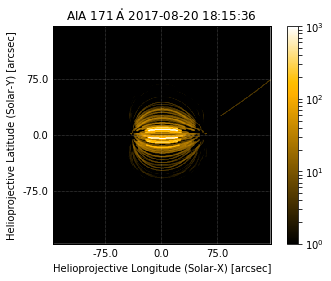

In [31]:
map_171_simple.peek(norm=matplotlib.colors.SymLogNorm(1e-6,vmin=1,vmax=1000))

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


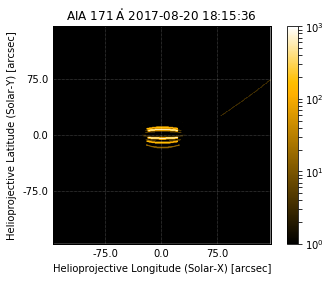

In [32]:
map_171_full.peek(norm=matplotlib.colors.SymLogNorm(1e-6,vmin=1,vmax=1000))

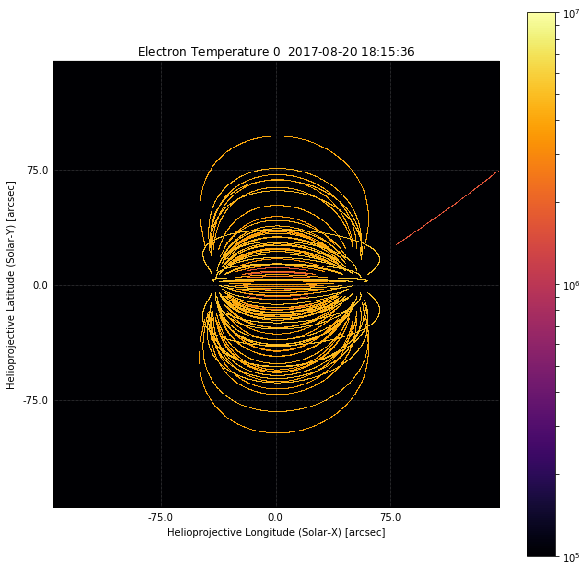

In [67]:
fig = plt.figure(figsize=(10,10))
foo = synthesizAR.maps.make_temperature_map(1110*u.s,field,aia)
#foo = foo.submap()
ax = fig.add_subplot(111,projection=foo)
foo.plot(norm=matplotlib.colors.SymLogNorm(1,vmin=1e5,vmax=1e7))
plt.colorbar()

In [ ]:
calc_temp_response = {}
for channel in aia.channels:
    counts = np.zeros(em_model.temperature.shape+em_model.density.shape)
    for ion in em_model:
        wvl,emiss = em_model.get_emissivity(ion)
        if wvl is None or emiss is None:
            continue
        response = scipy.interpolate.splev(wvl.value,channel['wavelength_response_spline'])
        response = np.where(response < 0., 0., response)
        tmp = np.dot(emiss.value,response)
        tmp *= ion.abundance.value*ion.ioneq.value[:,np.newaxis]/em_model.density.value/4./np.pi
        counts += tmp
    calc_temp_response[channel['name']] = counts

In [ ]:
const_p_indices = np.array([(i,np.argmin(np.fabs(density.value-d.value))) 
                            for i,d in enumerate(1e15/em_model.temperature)])

In [ ]:
fig,axes = plt.subplots(3,2,figsize=(10,15),sharex=True,sharey=True)
for i,(ax,channel) in enumerate(zip(axes.flatten(),aia.channels)):
    real_response = scipy.interpolate.splev(em_model.temperature.value,channel['temperature_response_spline'])
    ax.plot(em_model.temperature,real_response,
             color=seaborn.color_palette('deep')[i],ls='-',label=channel['name'])
    ax.plot(em_model.temperature,calc_temp_response[channel['name']][const_p_indices[:,0],const_p_indices[:,1]],
             color=seaborn.color_palette('deep')[i],ls='--')
    ax.axvline(x=1e6,ls='--',color='k')
    ax.axvline(x=1e7,ls='--',color='k')
    ax.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-30,2e-24])
plt.xlim([1e5,1e8])
#plt.legend()
plt.subplots_adjust(wspace=0.,hspace=0.)

## Parallelize Sandbox

In [14]:
@dask.delayed
def average_temperatures(loop_temperatures):
    return np.array(loop_temperatures).mean()

@dask.delayed
def slow_read(loop):
    time.sleep(5)
    electron_temperature = loop.electron_temperature
    return electron_temperature.value.mean()

@dask.delayed
def fast_read(loop):
    time.sleep(0.5)
    electron_temperature = loop.electron_temperature
    return electron_temperature.value.mean()

In [15]:
slow_reads = [slow_read(loop) for loop in field.loops[:50]]
fast_reads = [fast_read(loop) for loop in field.loops[50:]]
compute_avg = average_temperatures(slow_reads + fast_reads)

In [16]:
compute_avg.compute()

4176377.4098168071